# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

Firstly, let's load the datasets with the investment funds CNPJ (similar to a company ID in Brazil, can be used to identify uniquely a given investment fund),the share value at a given date, along with the volume of subscriptions and redemptions in Brazilian Reais:

In [2]:
historicSeries = pd.DataFrame()
for year in range(2017,2021):
    for month in range(1,13):
        file = "CVMData/inf_diario_fi_{0}{1}.csv".format(year,str(month).zfill(2))
        historicSeries = historicSeries.append(pd.read_csv(file, sep = ";"))
    print("{} inserted.".format(year))

historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]


2017 inserted.
2018 inserted.
2019 inserted.
2020 inserted.


Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [3]:
fundList = pd.read_excel("cad_fi_filtered.xlsx") 
#fundList = fundList.fillna("2099-01-01 00:00:00")
fundList=fundList.rename(columns={'CNPJ_FUNDO':'CNPJ'})

#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [4]:
ibov = yf.Ticker('^BVSP')
ibovHistoric = ibov.history(start="2016-12-31",end="2021-1-1")
ibovHistoricClose = ibovHistoric[["Close"]] 
ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

#### Random stuff about the SELIC rate

In [5]:
selicData = pd.read_json("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4189/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020")
selicData.head()
selicData["data"]=pd.to_datetime(selicData.data)
selicData = selicData.set_index("data") 

In [6]:
historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

On the scope of this study, only common Investment Funds ("FI") will be considered. Every form of Investment Fund in Brazil is regulated by CVM, so funds that have a specific purpose (e.g., FUNCINE funds, special investment funds whose objective is to support the movie industry) and certain funds that are closed-end funds (such as FII - Fundos de Investimento Imobiliário or Real Estate Investment Funds, similar to REITs) will be discarded.



Also, in order to provide a consistent first sample, only funds that happened to exist between December 31, 2016 and today or existed in January 1, 2017 and were closed in 2021 were considered.

In [7]:
def mount_FirstLayer(lowerLimit,upperLimit):
    firstFundFilterLayer = fundList[fundList["TP_FUNDO"]=="FI"]
    firstFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DT_REG"]<"2017-01-01"]
    firstFundFilterLayer = firstFundFilterLayer[(firstFundFilterLayer["SIT"]=="EM FUNCIONAMENTO NORMAL")]
    firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ'], keep='last')
    
    return firstFundFilterLayer

In [8]:
def mount_FinalLayers(firstFundFilterLayer):
    secondLayer = firstFundFilterLayer[firstFundFilterLayer["DENOM_SOCIAL"].str.contains("COTA")]
 
    fixedIncomeFundFilterLayer = secondLayer[secondLayer["CLASSE"].str.contains("Fundo de Renda Fixa")]
    #fixedIncomeFundFilterLayer[['CNPJ_FUNDO','DENOM_SOCIAL']]
 

    hedgeFundLayer = secondLayer[secondLayer["CLASSE"].str.contains("Fundo Multimercado")]
    
    #interbankRateFundFilterLayer = secondLayer[secondLayer["CLASSE"].str.contains("Fundo Referenciado")]
    
    return [fixedIncomeFundFilterLayer,hedgeFundLayer]

Afterwards, funds that use a master-feeder structure (a feeder fund that receive subscriptions and subscribes to a master fund, the fund that actually purchase securities and stock) will be filtered, considering only feeders (in portuguese, Fundos de Investimento em Cotas de Fundos de Investimentos).

In [9]:
def run_standard_analysis(historicSeries,fundList):
    
    dumpColumns = ['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']
    
    insightsFund = pd.DataFrame()
    insightsFund_SELIC = pd.DataFrame()
    insightsFund_Flow = pd.DataFrame()
    insightsFund_AvgTicket = pd.DataFrame()
    insightsFund_Dump = pd.DataFrame(columns=dumpColumns)

    dailyStatsHistoricSeries=historicSeries[historicSeries["CNPJ"].isin(fundList["CNPJ"])]
    dailyStatsHistoricSeries=dailyStatsHistoricSeries.rename(columns={"DT_COMPTC":"DATE"})
 
    for cnpj in fundList['CNPJ']:
        historicFundTemp = dailyStatsHistoricSeries[dailyStatsHistoricSeries['CNPJ']==cnpj]    
        historicFundTemp.set_index("DATE", inplace = True)  
        historicFundTemp = historicFundTemp.join(ibovHistoricClose)    
        historicFundTemp = historicFundTemp.dropna()
        historicFundTemp = historicFundTemp.join(selicData)
        
        
        
        stockCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CLOSE"]].corr().iloc[1,0]]]
        SELICCorrelation = [[cnpj,historicFundTemp[["NR_COTST","valor"]].corr().iloc[1,0]]]
        flowCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CAP_LIQ"]].corr().iloc[1,0]]]
        avgTicketCorrelation = [[cnpj,historicFundTemp[["NR_COTST","TKT_MED"]].corr().iloc[1,0]]]   
        vol = [[cnpj,historicFundTemp["VL_QUOTA"].std()/historicFundTemp["VL_QUOTA"].mean()]]
        
        insightsFund = insightsFund.append(stockCorrelation)   
        insightsFund_SELIC = insightsFund_SELIC.append(SELICCorrelation) 
        insightsFund_Flow = insightsFund_Flow.append(flowCorrelation) 
        insightsFund_AvgTicket = insightsFund_AvgTicket.append(avgTicketCorrelation) 
        insightsFund_Dump=insightsFund_Dump.append({'CNPJ':cnpj,'IbovCorrelation':stockCorrelation[0][1],'SELICCorrelation':SELICCorrelation[0][1],'flowCorrelation':flowCorrelation[0][1],'avgTicketCorrelation':avgTicketCorrelation[0][1],'vol':vol[0][1]},ignore_index=True)
        
    
    
    return [insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, insightsFund_Dump]

In [10]:
def plot_graphs(insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, binCount, main_Title):
    fig, axs = plt.subplots(1, 4, sharex=False, sharey=False)
    fig.set_size_inches(11,4)
    plt.suptitle(main_Title)

    axs[0].hist(insightsFund[[1]], bins=11)
    axs[0].set_title("shareholders vs stock market index")
    axs[0].set_xlabel("Correlations")
    axs[0].set_ylabel("# Funds")  


    axs[1].hist(insightsFund_SELIC[[1]], bins=11)
    axs[1].set_title("shareholders vs SELIC rates")
    axs[1].set_xlabel("Correlations")
    axs[1].set_ylabel("# Funds")  

    axs[2].hist(insightsFund_Flow[[1]], bins=11)
    axs[2].set_title("shareholders vs capital flow")
    axs[2].set_xlabel("Correlations")
    axs[2].set_ylabel("# Funds")  

    axs[3].hist(insightsFund_AvgTicket[[1]], bins=11)
    axs[3].set_title("shareholders vs avg ticket")
    axs[3].set_xlabel("Correlations")
    axs[3].set_ylabel("# Funds")      

    plt.tight_layout()
    
    plt.savefig("{}.png".format(main_Title))
    plt.show()

### hedgeFund

In [11]:
def hedgeFundAnalysis(startDate,endDate,hedgeFundLayer):
    hedgeFundHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(hedgeFundLayer["CNPJ"])]
    hedgeFundHistoricSeries = hedgeFundHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})
    
    hedgeFundHistoricSeries = hedgeFundHistoricSeries[(hedgeFundHistoricSeries['DATE']>=startDate)&(hedgeFundHistoricSeries['DATE']<=endDate)]
    
    results = run_standard_analysis(hedgeFundHistoricSeries,hedgeFundLayer)
    insightshedgeFund = results[0]
    insightshedgeFund_SELIC = results[1]
    insightshedgeFund_Flow = results[2]
    insightshedgeFund_AvgTicket = results[3]
    insightshedgeFund_Dump = results[4]
    plot_graphs(insightshedgeFund, insightshedgeFund_SELIC, insightshedgeFund_Flow, insightshedgeFund_AvgTicket,11,"Hedge Funds Results {}-{}".format(startDate[:4],endDate[:4]))
    insightshedgeFund_Dump.to_csv("hedgeFund_dump_{}-{}.csv".format(startDate,endDate))
    print("Hedge Fund Data Shape")
    print(insightshedgeFund_Dump.shape)

#### Fixed Income Rate Funds

In [12]:
def fixedIncomeAnalysis(startDate,endDate,fixedIncomeFundFilterLayer):

    fixedIncomeHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(fixedIncomeFundFilterLayer["CNPJ"])]
    fixedIncomeHistoricSeries = fixedIncomeHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})
    
    fixedIncomeHistoricSeries = fixedIncomeHistoricSeries[(fixedIncomeHistoricSeries['DATE']>=startDate)&(fixedIncomeHistoricSeries['DATE']<=endDate)]

    results = run_standard_analysis(fixedIncomeHistoricSeries,fixedIncomeFundFilterLayer)
    insightsFixedIncome = results[0]
    insightsFI_SELIC = results[1]
    insightsFI_Flow = results[2]
    insightsFI_AvgTicket = results[3]
    insightsFI_Dump = results[4]

    plot_graphs(insightsFixedIncome, insightsFI_SELIC, insightsFI_Flow, insightsFI_AvgTicket,11,"Fixed Income Funds Results {}-{}".format(startDate[:4],endDate[:4]))
    insightsFI_Dump.to_csv("fixedIncome_dump_{}-{}.csv".format(startDate,endDate))
    print("Fixed Income Rate Shape")
    print(insightsFI_Dump.shape)

### Yearly analysis

In [13]:
def analyze(lowerLimit, upperLimit):
 
    firstFundFilterLayer = mount_FirstLayer(lowerLimit,upperLimit)
    filters = mount_FinalLayers(firstFundFilterLayer)
    fixedIncomeFundFilterLayer = filters[0]
    hedgeFundLayer = filters[1]
    #interbankRateFundFilterLayer = filters[2]
      
    hedgeFundAnalysis(lowerLimit,upperLimit,hedgeFundLayer)
    #interbankAnalysis(lowerLimit,upperLimit,interbankRateFundFilterLayer)
    fixedIncomeAnalysis(lowerLimit,upperLimit,fixedIncomeFundFilterLayer)
    #privateBondAnalysis(lowerLimit,upperLimit,privateBondsFundFilterLayer)

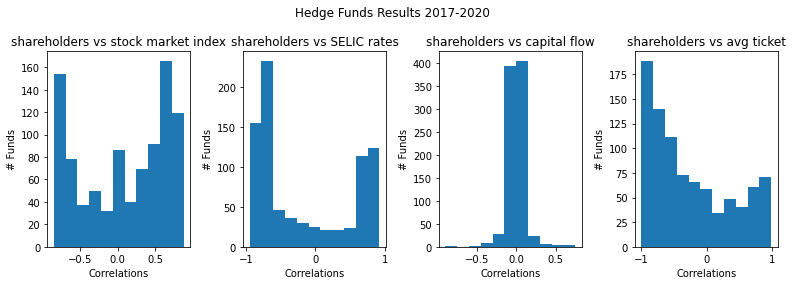

Hedge Fund Data Shape
(1537, 6)


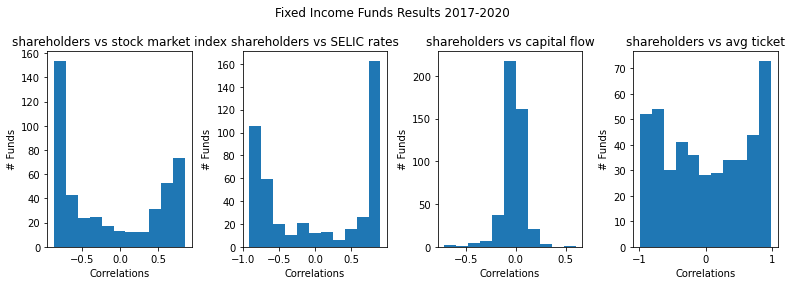

Fixed Income Rate Shape
(473, 6)


In [14]:
lowerLimit = "2017-01-01"
upperLimit = "2020-12-31"
analyze(lowerLimit, upperLimit)

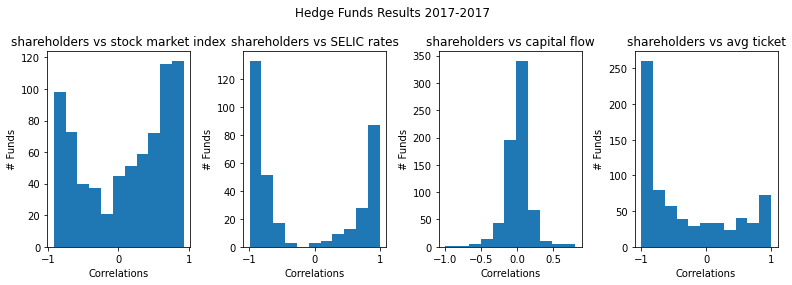

Hedge Fund Data Shape
(1537, 6)


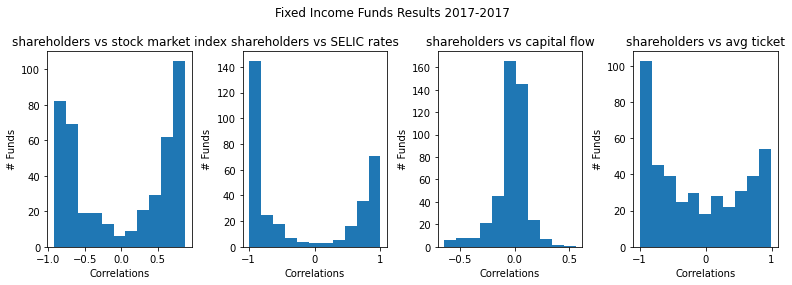

Fixed Income Rate Shape
(473, 6)


In [15]:
lowerLimit = "2017-01-01"
upperLimit = "2017-12-31"
analyze(lowerLimit, upperLimit)

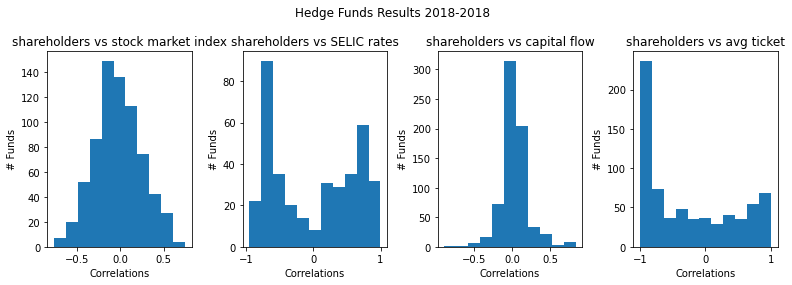

Hedge Fund Data Shape
(1537, 6)


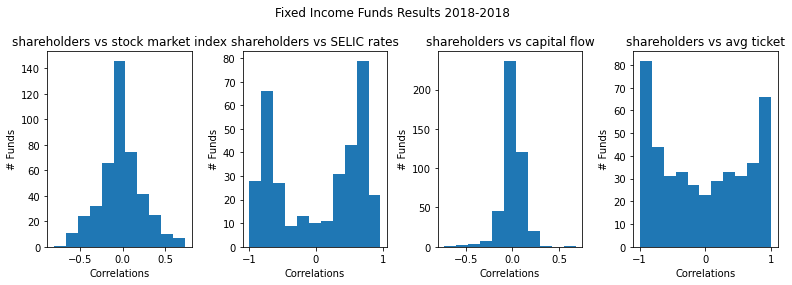

Fixed Income Rate Shape
(473, 6)


In [16]:
lowerLimit = "2018-01-01"
upperLimit = "2018-12-31"
analyze(lowerLimit, upperLimit)

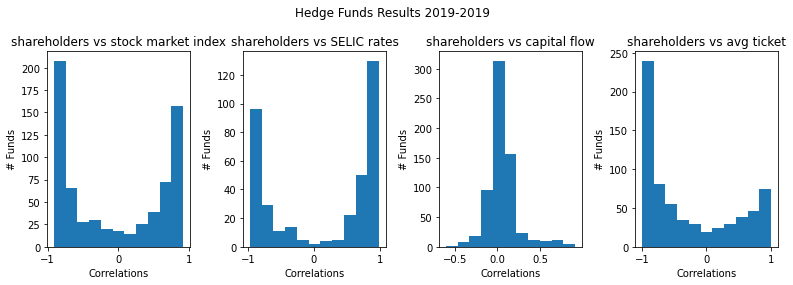

Hedge Fund Data Shape
(1537, 6)


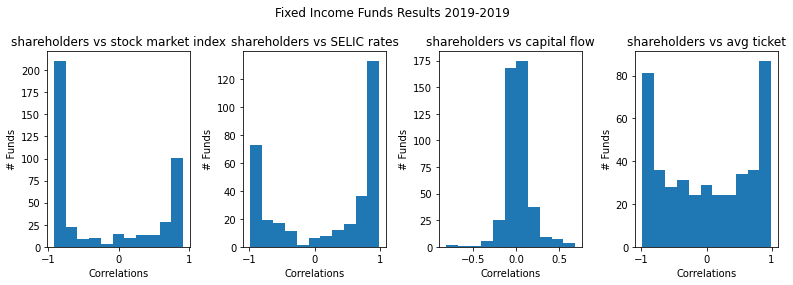

Fixed Income Rate Shape
(473, 6)


In [17]:
lowerLimit = "2019-01-01"
upperLimit = "2019-12-31"
analyze(lowerLimit, upperLimit)

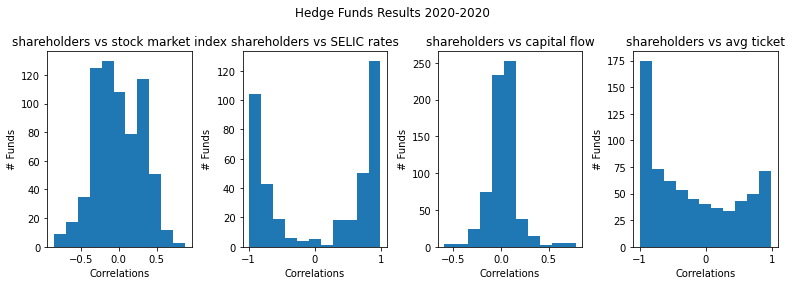

Hedge Fund Data Shape
(1537, 6)


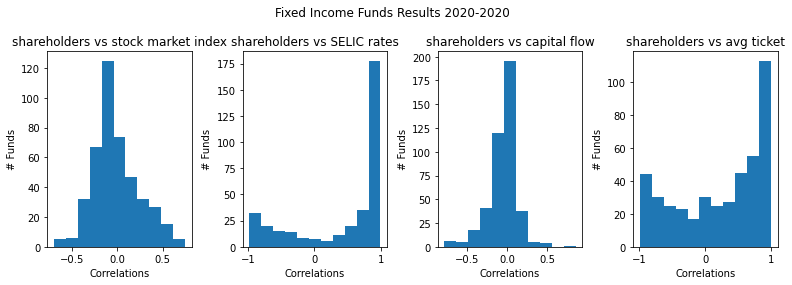

Fixed Income Rate Shape
(473, 6)


In [18]:
lowerLimit = "2020-01-01"
upperLimit = "2020-12-31"
analyze(lowerLimit, upperLimit)

In [22]:
lowerLimit = "2017-01-01"
upperLimit = "2020-12-31"
firstFundFilterLayer = mount_FirstLayer(lowerLimit,upperLimit)
filters = mount_FinalLayers(firstFundFilterLayer)
fixedIncomeFundFilterLayer = filters[0]
hedgeFundLayer = filters[1]



In [23]:
hedgeFundLayer

,TP_FUNDO,CNPJ,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
533,FI,00.089.915/0001-15,AMARIL FRANKLIN FUNDO DE INVESTIMENTO EM COTAS...,2005-07-08,1994-06-21,60097,NaT,EM FUNCIONAMENTO NORMAL,2005-07-08,1994-06-21,...,MERCANTIL DO BRASIL CORRETORA S/A CTVM,PJ,16.683.062/0001-85,MERCANTIL DO BRASIL CORRETORA S/A CTVM,16.888.455/0001-25,AUDSÉRVICE AUDITORES ASSOCIADOS SOCIEDADE SIMPLES,16.683.062/0001-85,MERCANTIL DO BRASIL CORRETORA S/A CTVM,16.683.062/0001-85,MERCANTIL DO BRASIL CORRETORA S/A CTVM
539,FI,00.346.750/0001-10,NIC YIELD FUNDO DE INVESTIMENTO EM COTAS DE FU...,2005-04-07,1995-09-19,48658,NaT,EM FUNCIONAMENTO NORMAL,2005-03-31,1995-09-19,...,NECTON INVESTIMENTOS S.A. CORRETORA DE VALORES...,PJ,52.904.364/0001-08,NECTON INVESTIMENTOS S.A. CORRETORA DE VALORES...,61.562.112/0001-20,PRICEWATERHOUSECOOPERS AUDITORES INDEPENDENTES,00.997.185/0001-50,BANCO B3 S.A.,52.904.364/0001-08,NECTON INVESTIMENTOS S.A. CORRETORA DE VALORES...
540,FI,00.400.490/0001-13,PORTO SEGURO MACRO FUNDO DE INVESTIMENTO EM CO...,2005-03-24,1995-01-19,36382,NaT,EM FUNCIONAMENTO NORMAL,2005-01-27,1995-02-01,...,INTRAG DTVM LTDA.,PJ,16.492.391/0001-49,PORTO SEGURO INVESTIMENTOS LTDA,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
543,FI,00.539.553/0001-17,GUIDE CASH FUNDO DE INVESTIMENTO EM COTAS DE F...,2005-02-11,1995-05-08,7552,NaT,EM FUNCIONAMENTO NORMAL,2005-01-27,1995-05-08,...,BNY MELLON SERVICOS FINANCEIROS DTVM S.A.,PJ,11.120.589/0001-88,GUIDE GESTÃO DE RECURSOS LTDA,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,42.272.526/0001-70,BNY MELLON BANCO S.A.,02.201.501/0001-61,BNY MELLON SERVICOS FINANCEIROS DTVM S.A.
555,FI,00.826.903/0001-26,CSHG TOP FUNDO DE INVESTIMENTO EM COTAS DE FUN...,2005-04-05,1995-10-02,47155,NaT,EM FUNCIONAMENTO NORMAL,2005-03-21,1995-10-02,...,CREDIT SUISSE HEDGING-GRIFFO CORRETORA DE VALO...,PJ,68.328.632/0001-12,CREDIT SUISSE HEDGING-GRIFFO WEALTH MANAGEMENT...,61.562.112/0001-20,PRICEWATERHOUSECOOPERS AUDITORES INDEPENDENTES,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19230,FI,26.744.778/0001-07,CSHG BM TOP FUNDO DE INVESTIMENTO EM COTAS DE ...,2016-12-23,2016-11-24,270245,NaT,EM FUNCIONAMENTO NORMAL,2017-04-17,2017-04-17,...,CREDIT SUISSE HEDGING-GRIFFO CORRETORA DE VALO...,PJ,68.328.632/0001-12,CREDIT SUISSE HEDGING-GRIFFO WEALTH MANAGEMENT...,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
21662,FI,97.525.440/0001-02,CSHG LUPA HEDGE FUNDO DE INVESTIMENTO EM COTAS...,2011-09-16,2011-09-13,168661,NaT,EM FUNCIONAMENTO NORMAL,2011-10-04,2011-10-04,...,CREDIT SUISSE HEDGING-GRIFFO CORRETORA DE VALO...,PJ,68.328.632/0001-12,CREDIT SUISSE HEDGING-GRIFFO WEALTH MANAGEMENT...,61.562.112/0001-20,PRICEWATERHOUSECOOPERS AUDITORES INDEPENDENTES,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
21666,FI,97.525.454/0001-18,MDLT FUNDO DE INVESTIMENTO EM COTAS FUNDOS DE ...,2011-08-16,2011-08-15,166960,NaT,EM FUNCIONAMENTO NORMAL,2012-02-01,2012-02-01,...,ITAU UNIBANCO S.A.,PJ,33.311.713/0001-25,ITAÚ DTVM S.A.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
21673,FI,97.711.801/0001-05,953 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS D...,2011-10-04,2011-07-07,169390,NaT,EM FUNCIONAMENTO NORMAL,2011-10-07,2011-10-07,...,CREDIT SUISSE HEDGING-GRIFFO CORRETORA DE VALO...,PJ,10.639.564/0001-22,WRIGHT CAPITAL GESTAO DE RECURSOS LTDA,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.


In [24]:
fixedIncomeFundFilterLayer

,TP_FUNDO,CNPJ,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
21678,FI,00.068.305/0001-35,FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE IN...,2004-12-22,1994-05-26,744,NaT,EM FUNCIONAMENTO NORMAL,2004-12-02,1994-05-26,...,CAIXA ECONOMICA FEDERAL,PJ,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL
21679,FI,00.071.477/0001-68,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA F...,2005-03-29,1994-05-19,40584,NaT,EM FUNCIONAMENTO NORMAL,2005-03-24,1994-05-19,...,BB GESTAO DE RECURSOS DTVM S.A,PJ,30.822.936/0001-69,BB GESTAO DE RECURSOS DTVM S.A,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,00.000.000/0001-91,BANCO DO BRASIL S.A.,00.000.000/0001-91,BANCO DO BRASIL S.A.
21681,FI,00.180.995/0001-10,SAFRA EXECUTIVE MAX RF FUNDO DE INVESTIMENTO E...,2005-02-15,1994-09-06,10189,NaT,EM FUNCIONAMENTO NORMAL,2005-02-01,1994-09-06,...,SAFRA SERVIÇOS DE ADMINISTRAÇÃO FIDUCIÁRIA LTDA.,PJ,62.180.047/0001-31,SAFRA ASSET MANAGEMENT LTDA.,49.928.567/0001-11,DELOITTE TOUCHE TOHMATSU AUDITORES INDEPENDENTES,58.160.789/0001-28,BANCO SAFRA S/A,58.160.789/0001-28,BANCO SAFRA S/A
21685,FI,00.222.816/0001-60,SAFRA EXECUTIVE FUNDO DE INVESTIMENTO EM COTAS...,2005-02-15,1994-09-30,9580,NaT,EM FUNCIONAMENTO NORMAL,2005-02-01,1994-09-30,...,SAFRA SERVIÇOS DE ADMINISTRAÇÃO FIDUCIÁRIA LTDA.,PJ,62.180.047/0001-31,SAFRA ASSET MANAGEMENT LTDA.,49.928.567/0001-11,DELOITTE TOUCHE TOHMATSU AUDITORES INDEPENDENTES,58.160.789/0001-28,BANCO SAFRA S/A,58.160.789/0001-28,BANCO SAFRA S/A
21697,FI,00.756.851/0001-69,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE IN...,2005-03-29,1995-08-07,40649,NaT,EM FUNCIONAMENTO NORMAL,2005-03-24,1995-08-07,...,BB GESTAO DE RECURSOS DTVM S.A,PJ,30.822.936/0001-69,BB GESTAO DE RECURSOS DTVM S.A,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,00.000.000/0001-91,BANCO DO BRASIL S.A.,00.000.000/0001-91,BANCO DO BRASIL S.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26335,FI,68.599.141/0001-06,BB RENDA FIXA LP AUTOMATICO FUNDO DE INVESTIME...,2005-03-30,1992-08-17,41335,NaT,EM FUNCIONAMENTO NORMAL,2005-03-24,1992-08-17,...,BB GESTAO DE RECURSOS DTVM S.A,PJ,30.822.936/0001-69,BB GESTAO DE RECURSOS DTVM S.A,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,00.000.000/0001-91,BANCO DO BRASIL S.A.,00.000.000/0001-91,BANCO DO BRASIL S.A.
26336,FI,68.623.479/0001-56,FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE IN...,2004-12-22,1992-10-28,841,NaT,EM FUNCIONAMENTO NORMAL,2004-12-02,1992-10-28,...,CAIXA ECONOMICA FEDERAL,PJ,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL,00.360.305/0001-04,CAIXA ECONOMICA FEDERAL
26339,FI,68.971.183/0001-26,MAXI DI IB RENDA FIXA REFERENCIADO DI FUNDO DE...,2005-02-28,1992-09-30,12238,NaT,EM FUNCIONAMENTO NORMAL,2005-02-24,1992-09-30,...,ITAU UNIBANCO S.A.,PJ,60.701.190/0001-04,ITAU UNIBANCO S.A.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
26348,FI,97.519.703/0001-62,ITAÚ PRIVATE ACTIVE FIX 5 RENDA FIXA CRÉDITO P...,2011-09-13,2011-09-09,168440,NaT,EM FUNCIONAMENTO NORMAL,2011-09-14,2011-09-14,...,ITAU UNIBANCO S.A.,PJ,60.701.190/0001-04,ITAU UNIBANCO S.A.,49.928.567/0001-11,DELOITTE TOUCHE TOHMATSU AUDITORES INDEPENDENTES,60.701.190/0001-04,ITAU UNIBANCO S.A.,60.701.190/0001-04,ITAU UNIBANCO S.A.
